In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import os

### Data exploration
['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33']

In [10]:
df = pd.read_csv('dataset_mood_smartphone.csv')
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [4]:
df["id_num"] = df["id"].apply(lambda x: int(x.split(".")[1]))
print(df["id_num"].unique())
df["id"].unique()





[ 1  2  3  5  6  7  8  9 12 13 14 15 16 17 19 20 23 24 25 26 27 28 29 30
 31 32 33]


array(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33'], dtype=object)

In [5]:
# convert time to datetime


df["time"] = pd.to_datetime(df["time"])



In [6]:
for person in df["id_num"].unique():
    print("PERSON", person)
    df_person = df[df["id_num"] == person]
    # print(df_person["variable"].unique())
    # print(df_person["variable"].value_counts())
    # print(df_person["value"].describe())
    # print(df_person["time"].describe())
    # print(df_person["time"].max() - df_person["time"].min())
    # print(df_person["time"].max())
    # print(df_person["time"].min())

    for var in df_person["variable"].unique():
        print(var)
        df_var = df_person[df_person["variable"] == var]
        print(df_var["value"].describe())
        print(df_var["time"].describe())
        print(f"DIFFERENCE FOR {var}", df_var["time"].max() - df_var["time"].min())
        print(df_var["time"].max())
        print(df_var["time"].min())


PERSON 1
mood
count    222.000000
mean       7.067568
std        0.845500
min        4.000000
25%        7.000000
50%        7.000000
75%        8.000000
max        9.000000
Name: value, dtype: float64
count                              222
mean     2014-04-11 06:06:45.405405440
min                2014-02-26 13:00:00
25%                2014-03-31 09:45:00
50%                2014-04-11 20:00:00
75%                2014-04-23 14:00:00
max                2014-05-04 21:00:00
Name: time, dtype: object
DIFFERENCE FOR mood 67 days 08:00:00
2014-05-04 21:00:00
2014-02-26 13:00:00
circumplex.arousal
count    218.000000
mean      -0.243119
std        0.905983
min       -2.000000
25%       -1.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: value, dtype: float64
count                              223
mean     2014-04-11 07:53:48.699551744
min                2014-02-26 13:00:00
25%                2014-03-31 10:30:00
50%                2014-04-11 22:00:00
75%                2

In [7]:
df_person_1 = df[df["id_num"] == 1].copy()

# df_person_1["time"].nunique()

# count which number occurs twice

# split the values into variable columns with unique time values

# count unique days in time
# print(df_person_1["time"].dt.date.nunique())

# rename time into date-time
df_person_1 = df_person_1.rename(columns={"time": "datetime"})
df_person_1["date"] = df_person_1["datetime"].dt.date
df_person_1["hour"] = df_person_1["datetime"].dt.hour
df_person_1["minute"] = df_person_1["datetime"].dt.minute
df_person_1



,Unnamed: 0,id,datetime,variable,value,id_num,date,hour,minute
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.000,1,2014-02-26,13,0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.000,1,2014-02-26,15,0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.000,1,2014-02-26,18,0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.000,1,2014-02-26,21,0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.000,1,2014-02-27,9,0
...,...,...,...,...,...,...,...,...,...
374684,2348657,AS14.01,2014-05-05 00:15:26.313,appCat.utilities,164.567,1,2014-05-05,0,15
374685,2348659,AS14.01,2014-05-05 00:18:14.953,appCat.utilities,48.138,1,2014-05-05,0,18
374686,2348660,AS14.01,2014-05-05 00:19:42.322,appCat.utilities,48.156,1,2014-05-05,0,19
374687,2348691,AS14.01,2014-05-05 09:41:03.888,appCat.utilities,3.470,1,2014-05-05,9,41


/var/folders/f9/4f7hqdfs2fjbhkvbpghqwvd00000gn/T/ipykernel_7566/2099611800.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 0.3 * len(stats)))  # Adjust height based on number of variables


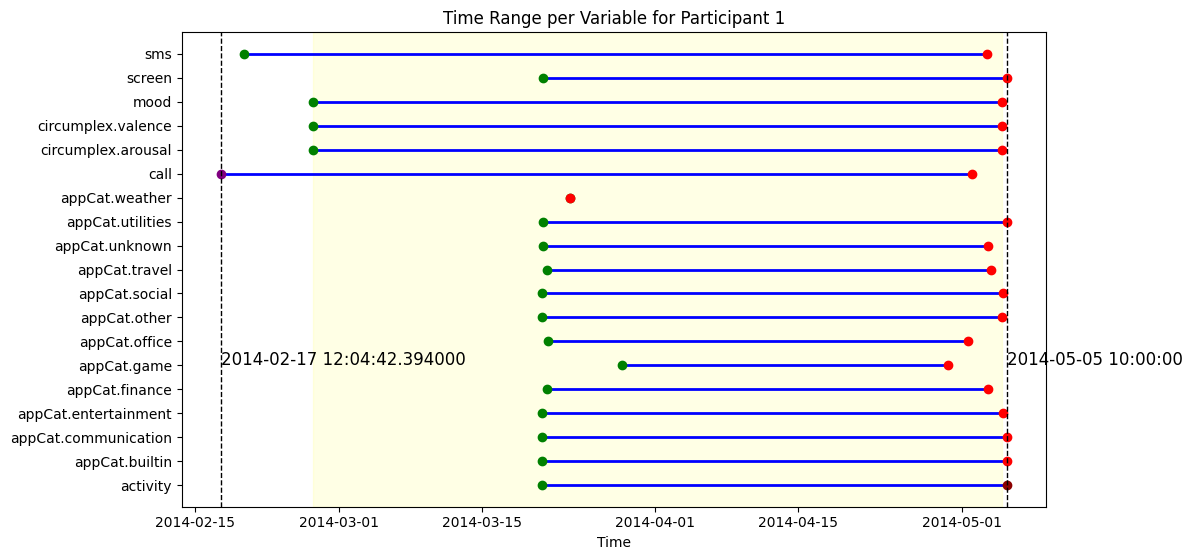

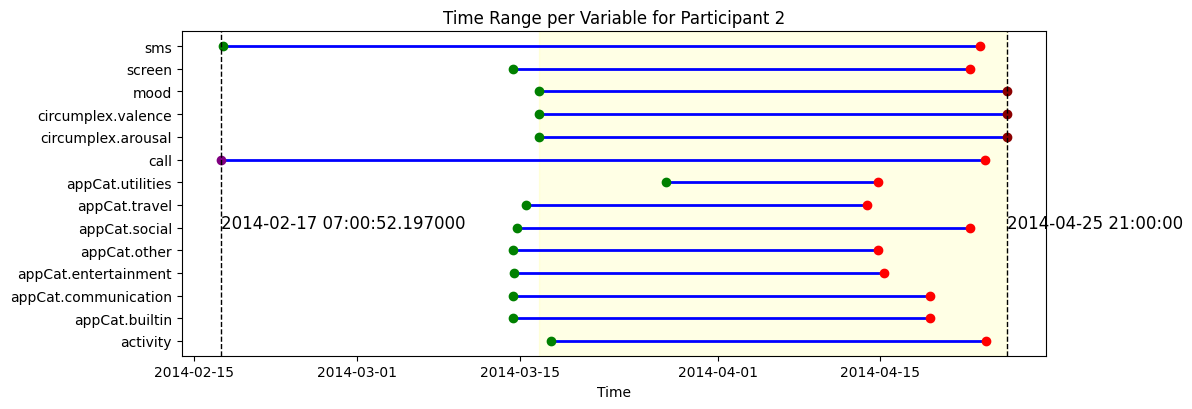

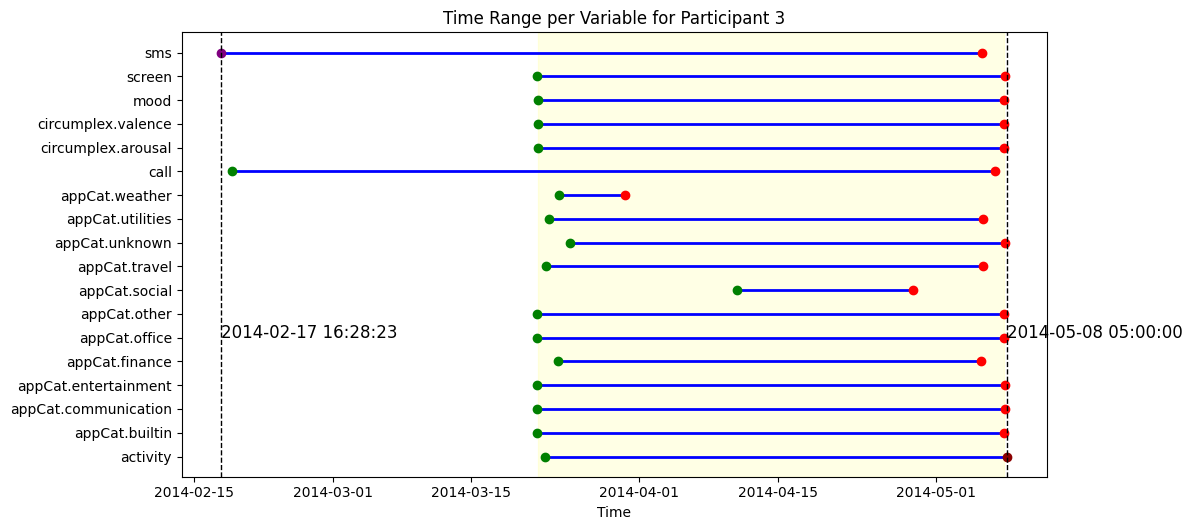

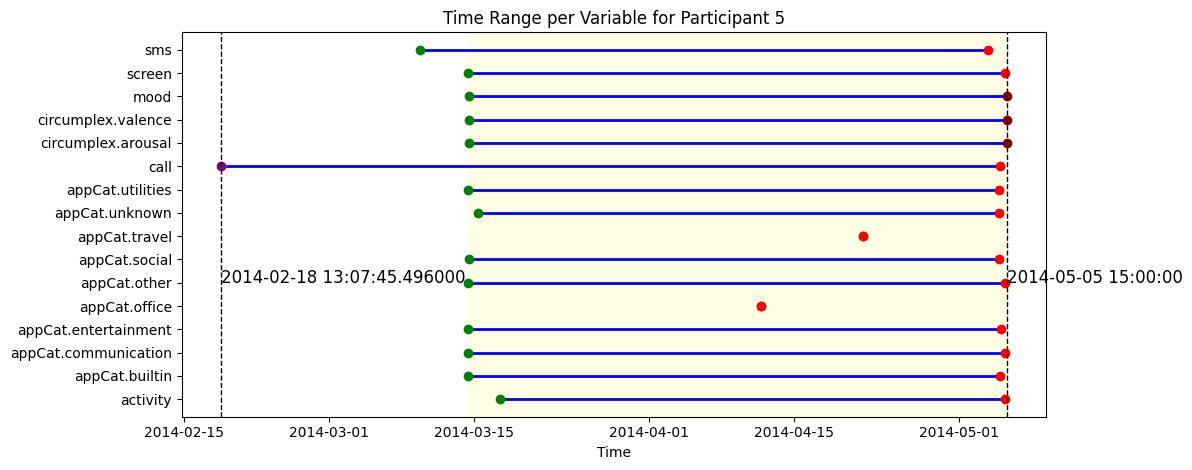

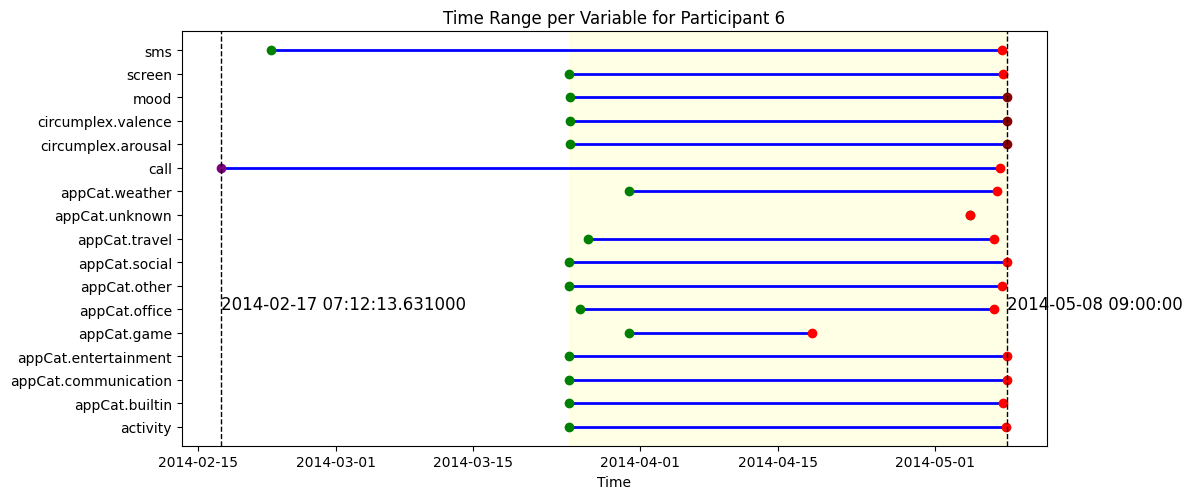

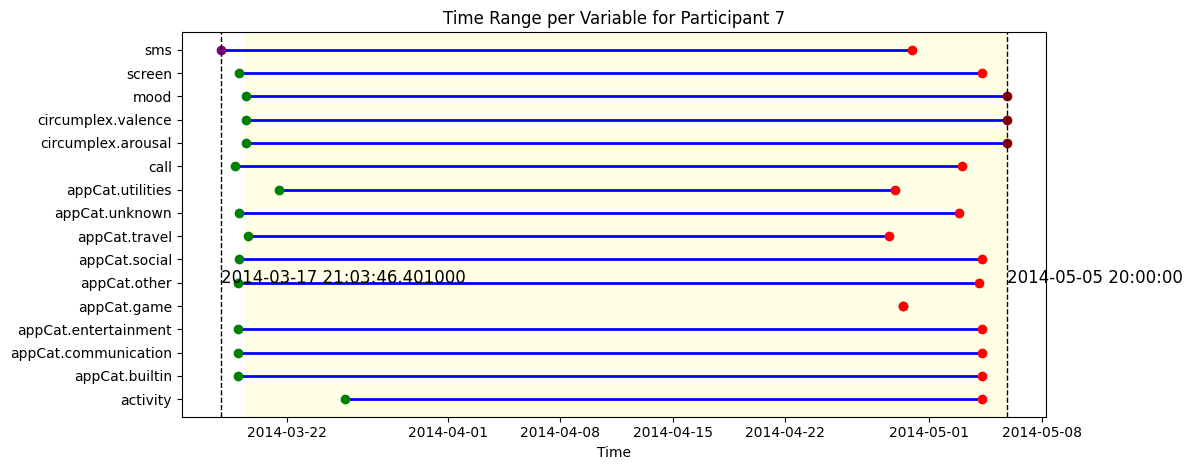

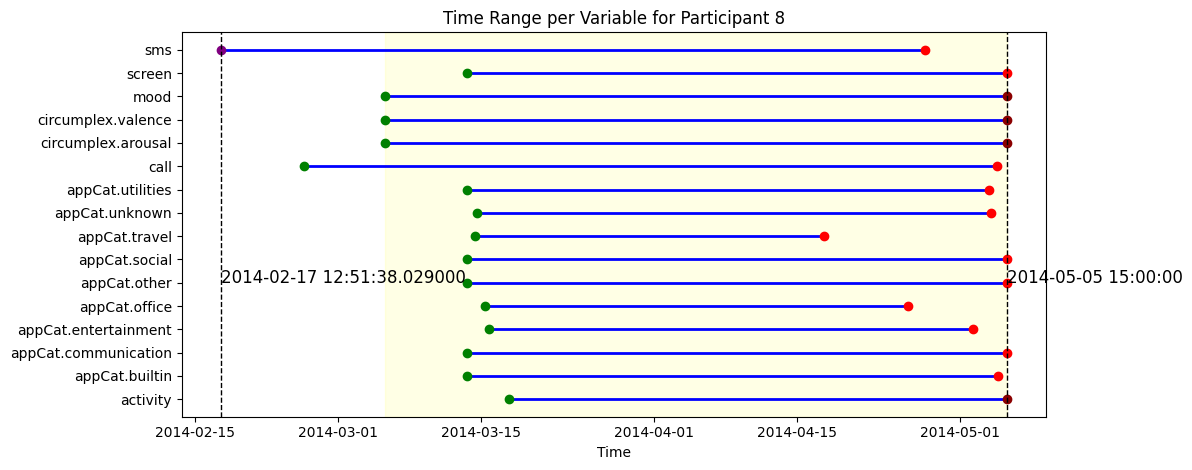

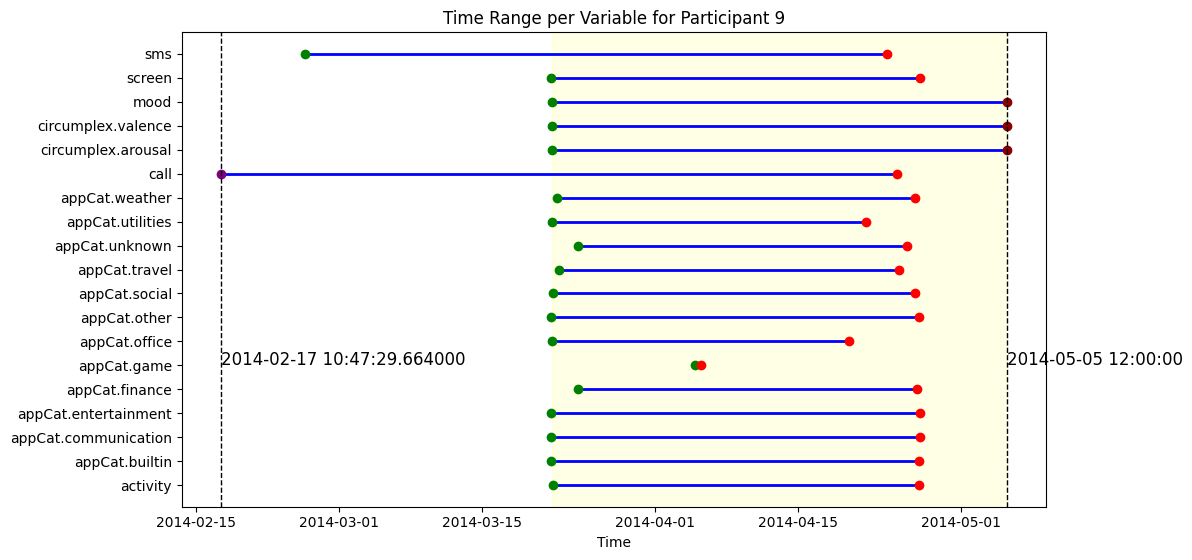

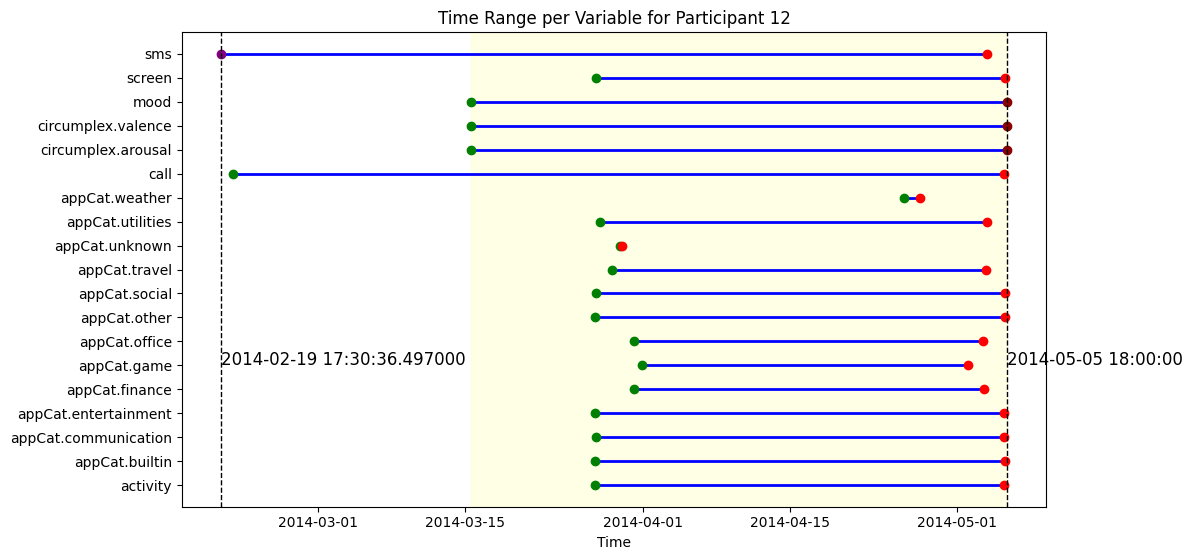

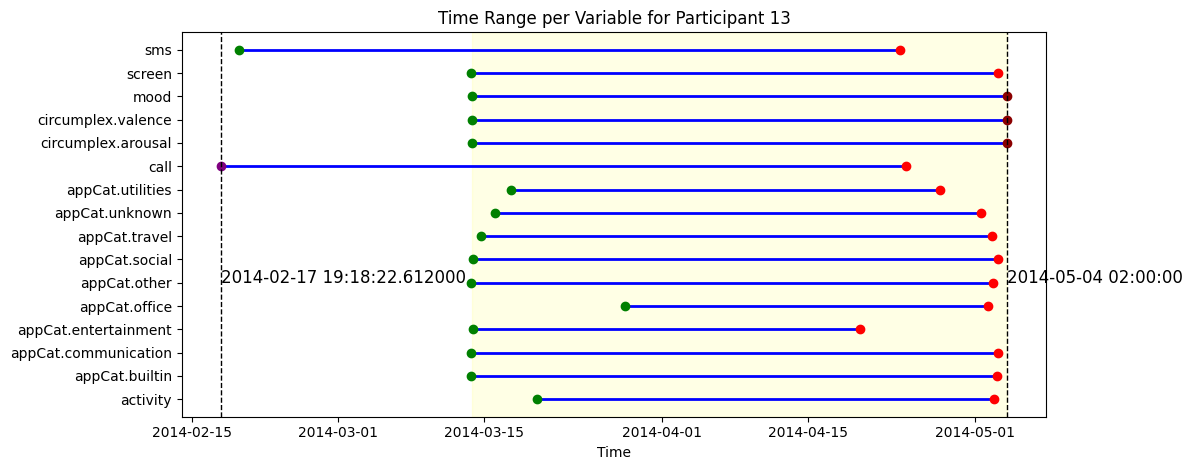

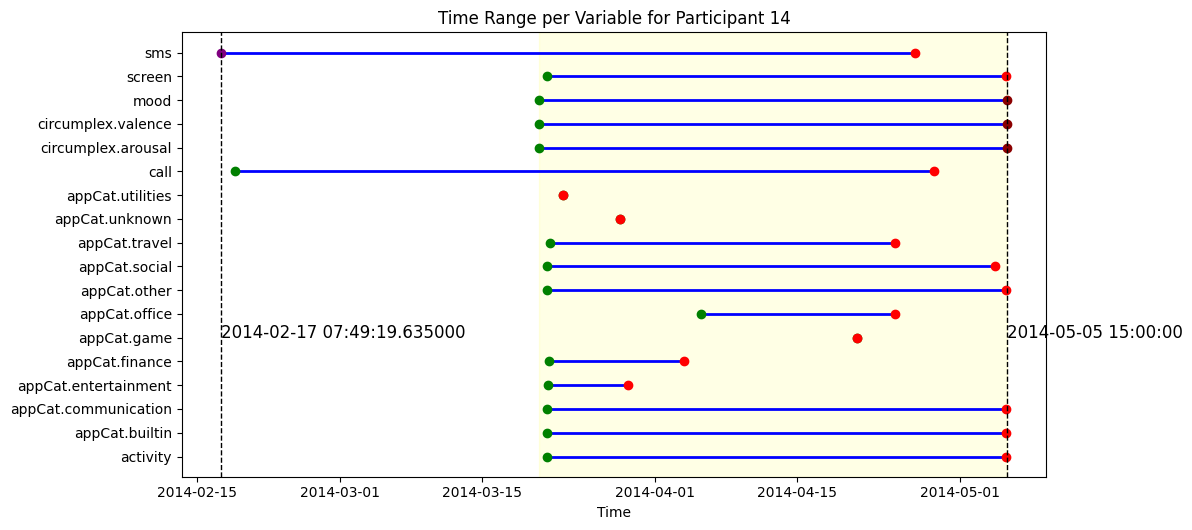

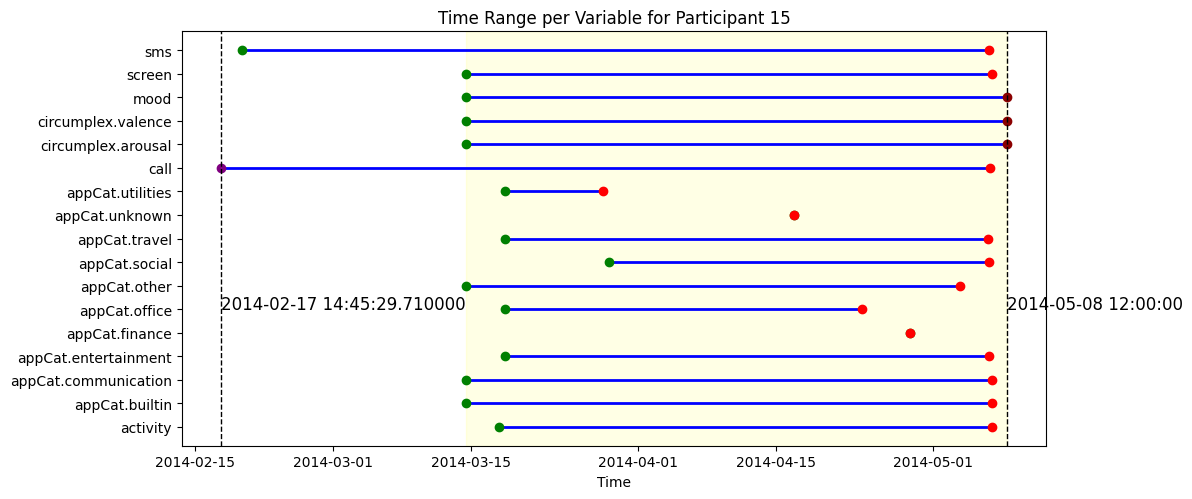

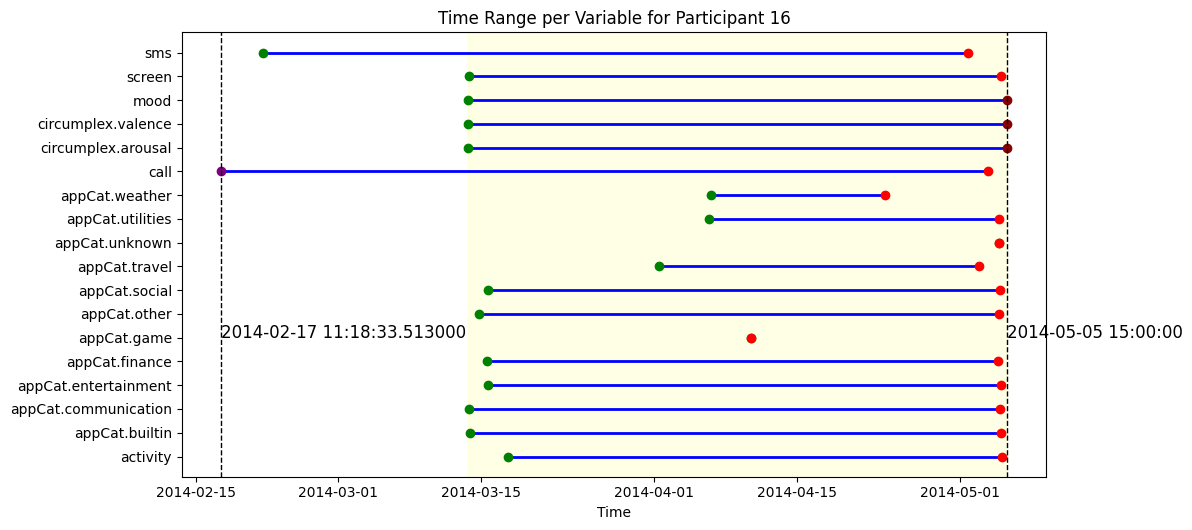

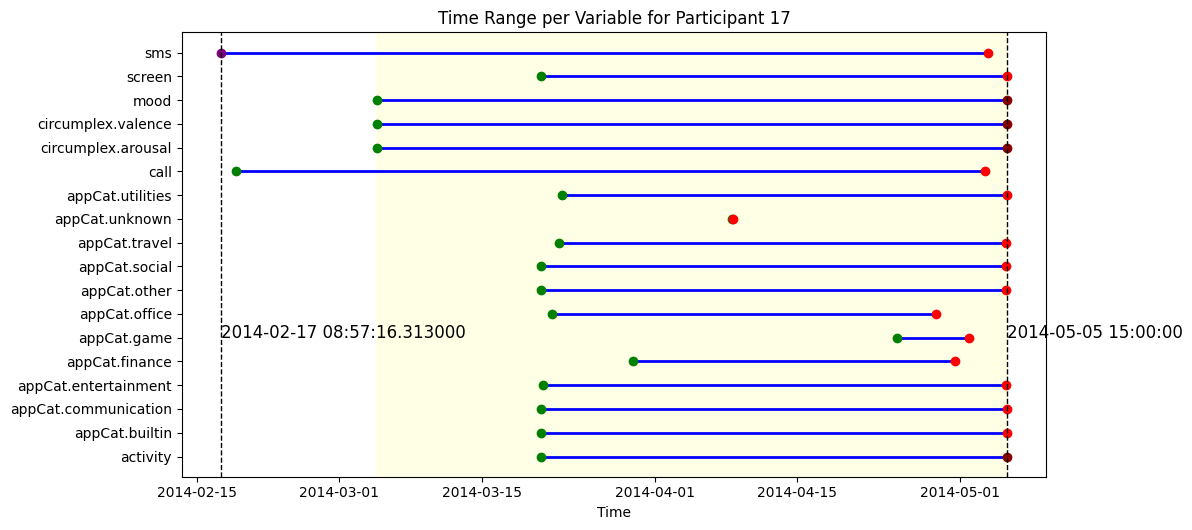

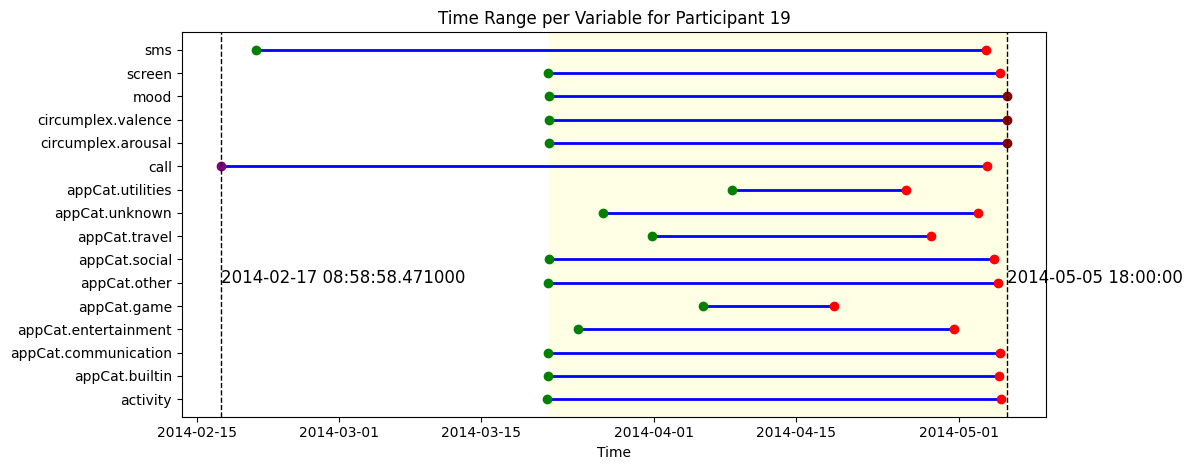

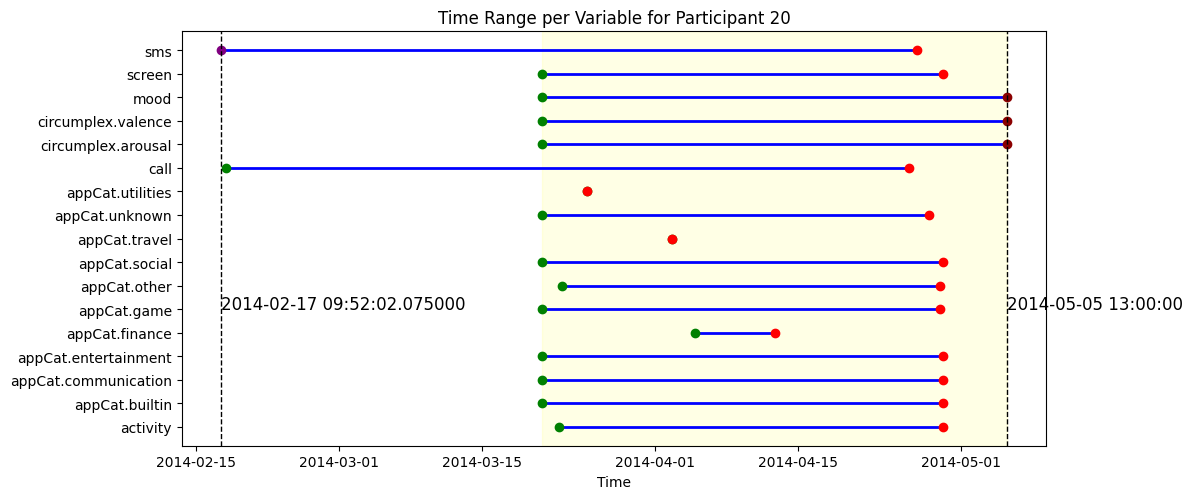

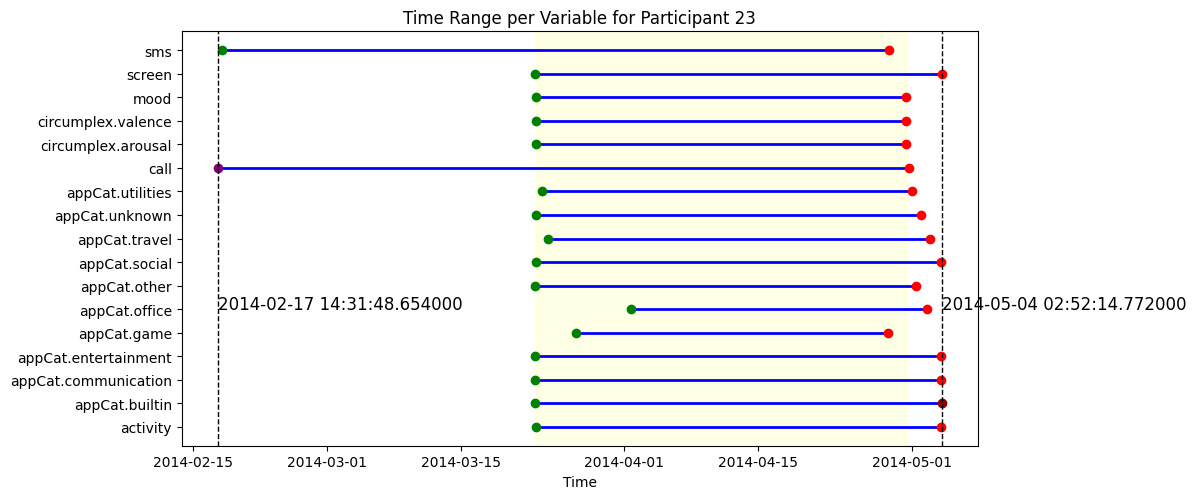

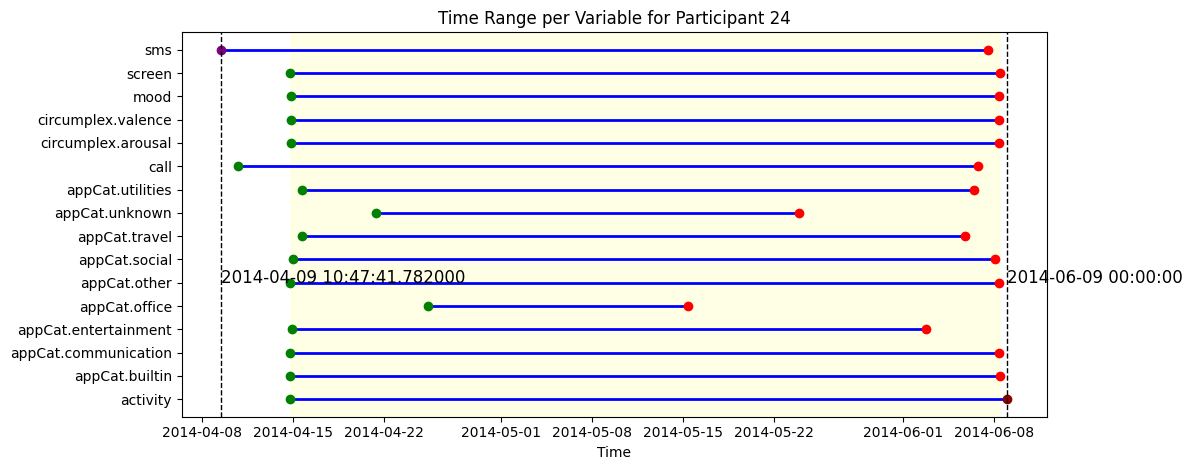

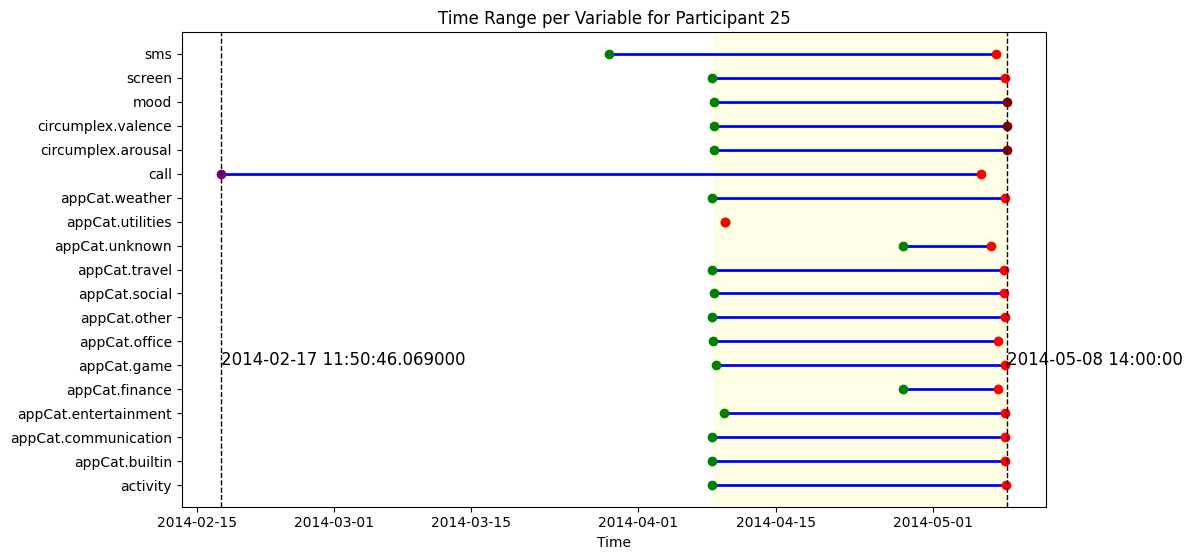

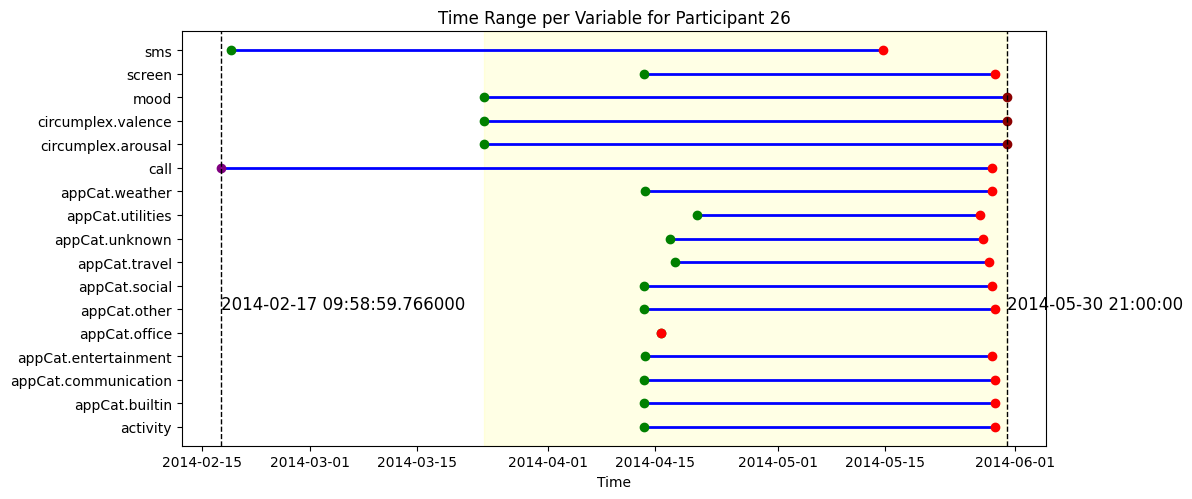

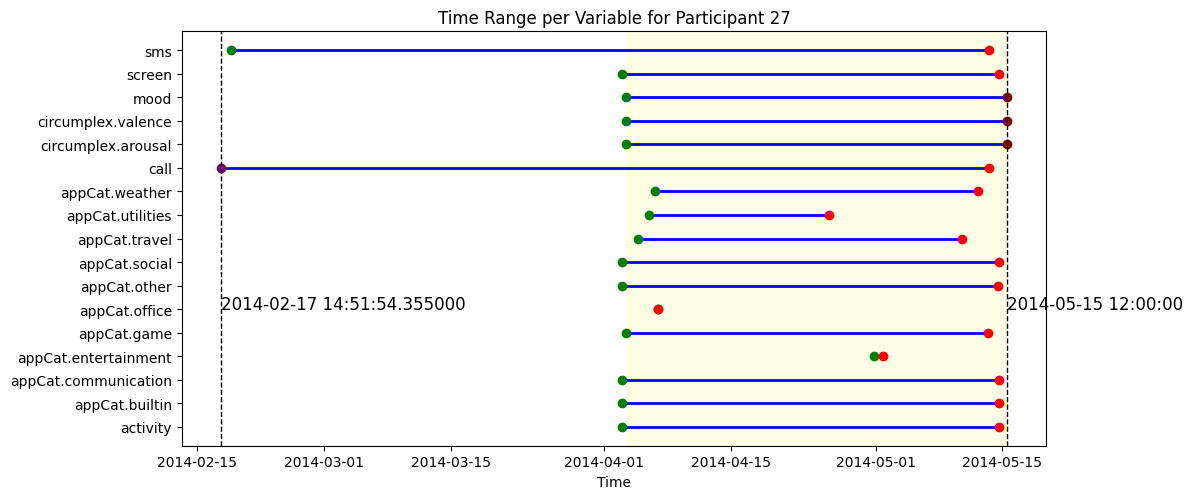

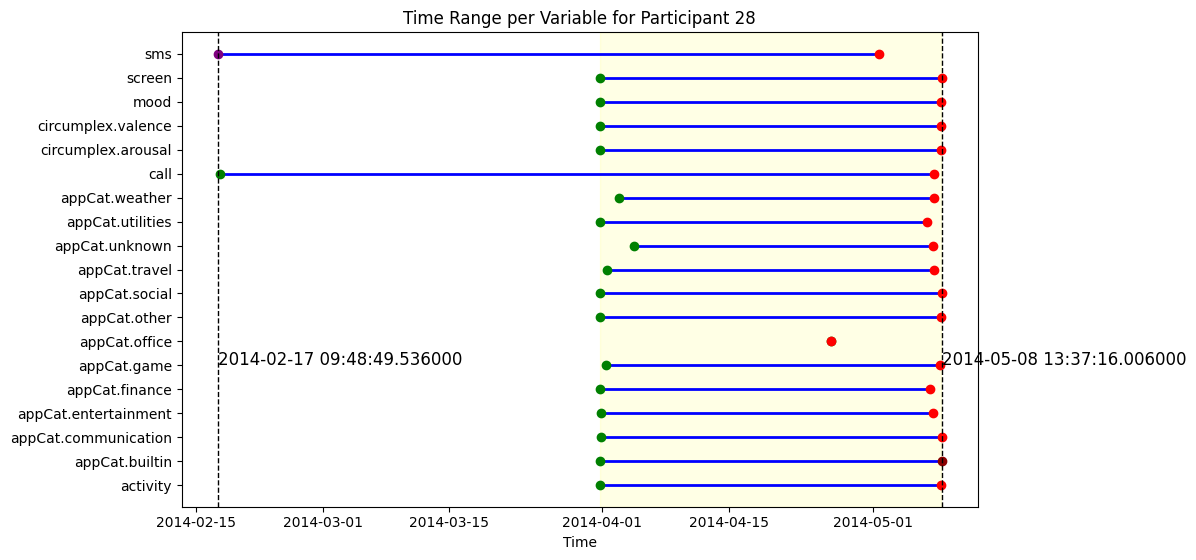

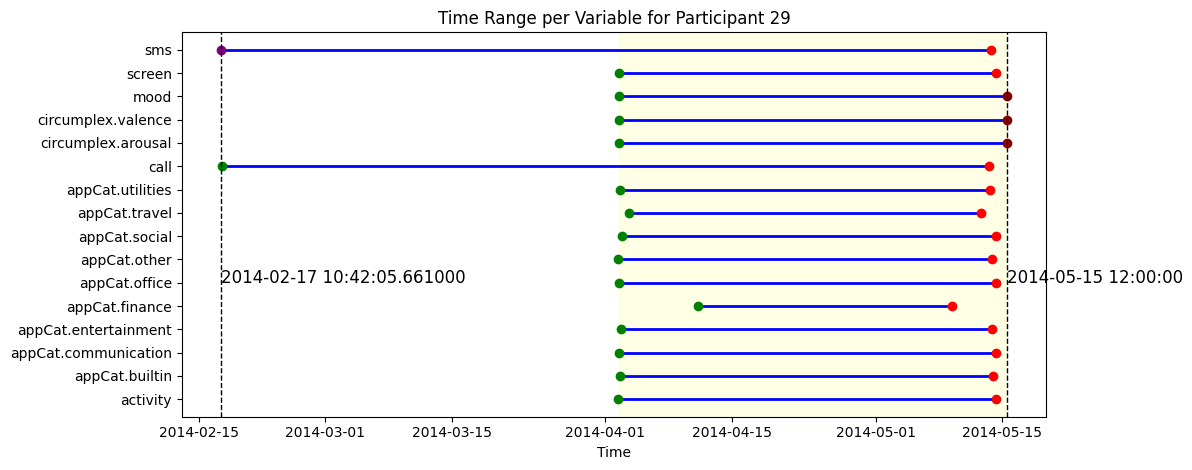

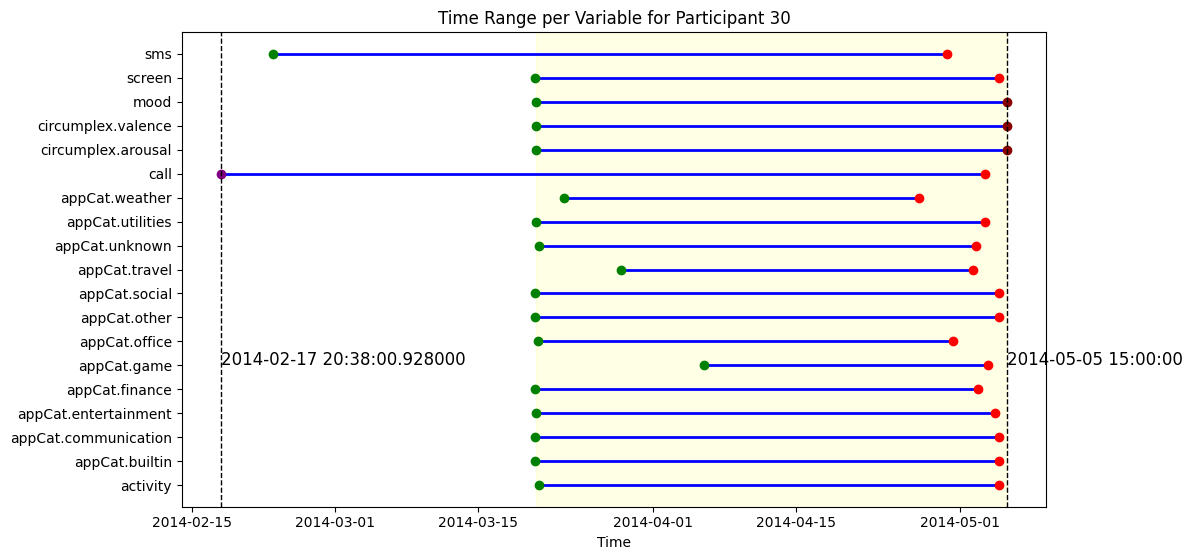

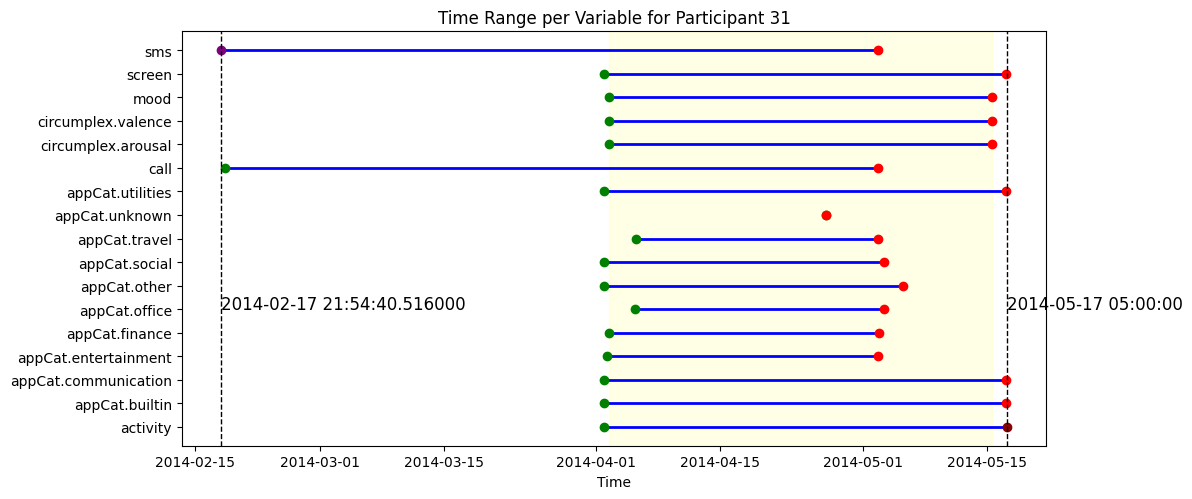

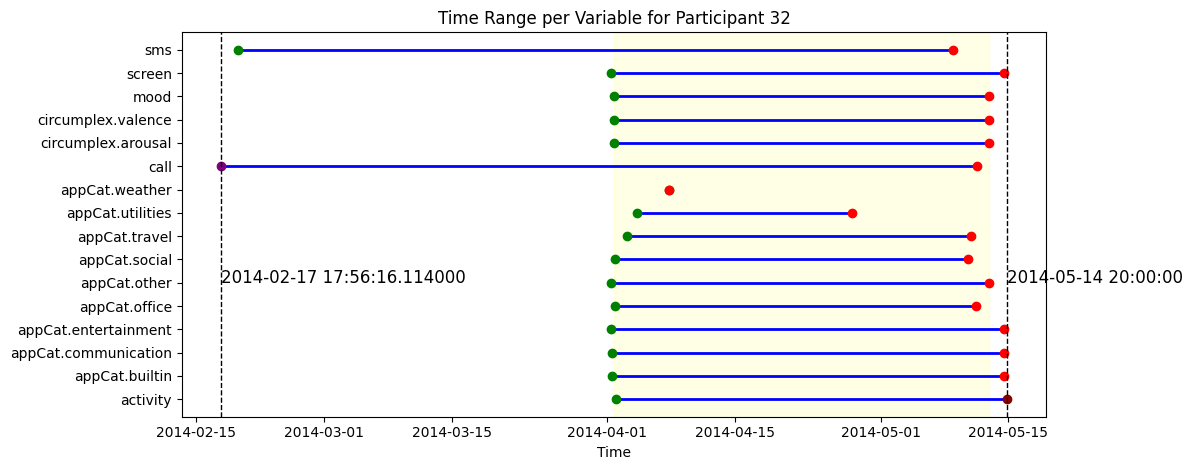

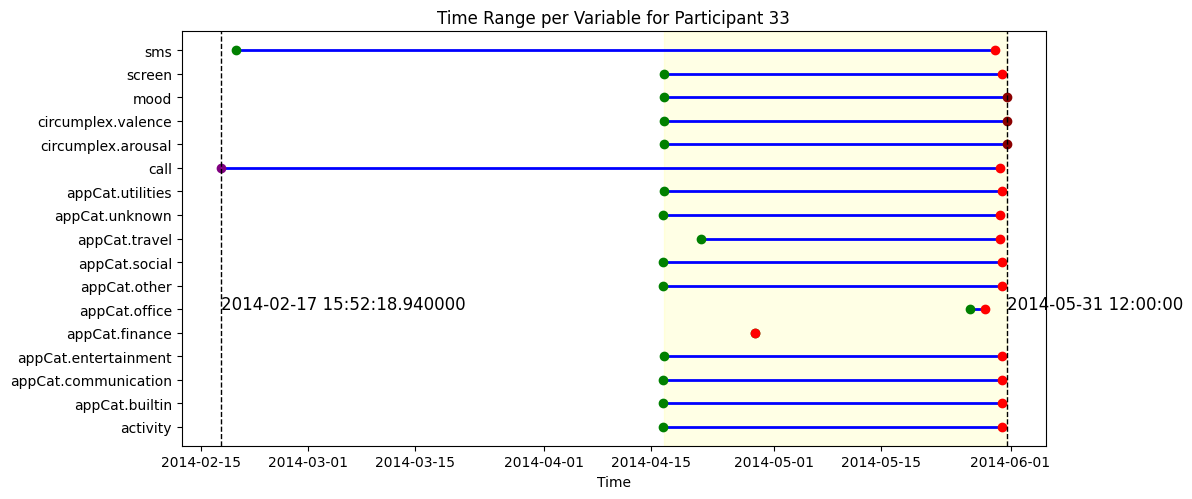

In [8]:
def get_time_descriptives(df, participant: int):
    """
    Get time descriptives for a given participant.
    """
    # Filter for the participant
    df_person = df[df["id_num"] == participant].copy()

    # rename time into datetime
    # print(df_person.columns) 
    
    # Group by variable and compute descriptive statistics
    stats = df_person.groupby("variable")["time"].agg(
        count_non_missing = "count",
        min_time = "min",
        max_time = "max"
    )
    # Count missing values per variable
    stats["n_missing"] = df_person.groupby("variable")["time"].apply(lambda x: x.isna().sum())
    # Calculate the time range (difference between max and min)
    stats["time_range"] = stats["max_time"] - stats["min_time"]
    
    # Optionally, reset the index for a nicer display
    stats = stats.reset_index()
    return stats


def plot_time_ranges(df, participant, save_fig=True, show_plot=True):
    """
    Plot the time range for each variable for a given participant.
    """
    # Get descriptive stats for plotting
    stats = get_time_descriptives(df, participant)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 0.3 * len(stats)))  # Adjust height based on number of variables
    
    # Loop over each variable to draw its time range as a horizontal line
    earliest = stats["min_time"].min()
    latest = stats["max_time"].max()
    for idx, row in stats.iterrows():
        ax.hlines(y=idx, xmin=row["min_time"], xmax=row["max_time"], color='blue', lw=2)

        # Optionally, mark the endpoints
        if row["min_time"] == earliest:
            ax.plot(row["min_time"], idx, "o", color='purple')
        else:
            ax.plot(row["min_time"], idx, "o", color='green')
        if row["max_time"] == latest:
            ax.plot(row["max_time"], idx, "o", color='darkred')
        else:
            ax.plot(row["max_time"], idx, "o", color='red')

    # higlight background between the earliest and latest time of mood
    earliest_mood = stats[stats["variable"] == "mood"]["min_time"].values[0]
    latest_mood = stats[stats["variable"] == "mood"]["max_time"].values[0]
    ax.axvspan(earliest_mood, latest_mood, alpha=0.1, color='yellow')


    # get the earliest and latest time and write it to the plot

    plt.text(earliest, 5, earliest, color='black', fontsize=12)
    plt.text(latest, 5, latest, color='black', fontsize=12)
    
    # line for earliest and latest time
    ax.axvline(earliest, color='black', linestyle='--', lw=1)
    ax.axvline(latest, color='black', linestyle='--', lw=1)
    
    # Customize y-axis with variable names
    ax.set_yticks(range(len(stats)))
    ax.set_yticklabels(stats["variable"])
    ax.set_xlabel("Time")
    ax.set_title("Time Range per Variable for Participant {}".format(participant))


    plt.tight_layout()


    # save figure
    if save_fig:
        if not os.path.exists("figures/time_ranges_per_variable"):
            os.makedirs("figures/time_ranges_per_variable")
        plt.savefig(f"figures/time_ranges_per_variable/time_range_plot_p{participant}.png")
    
    # add one legend for all lines

    if show_plot:
        plt.show()



for person in df["id_num"].unique():
    # print(f"Participant {person}")
    stats = get_time_descriptives(df, person)
    # print(stats)
    plot_time_ranges(df, person, save_fig=True, show_plot=False)


In [9]:
def create_daily_pivot(df, participant: int):
    """
    Create a daily pivot table for a given participant.
    
    Each row corresponds to a day (from the earliest to the latest day the participant has data),
    each column corresponds to a variable, and if multiple datapoints occur on a given day,
    the value is aggregated as the mean. Days with no data for a variable are represented as NaN.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing at least the columns 'id_num', 'datetime', 
                           'variable', and 'value'. 'datetime' should be in datetime format.
        participant: Identifier for the participant to filter the data (column 'id_num').
    
    Returns:
        pd.DataFrame: A pivot table indexed by day with variables as columns.
    """
    # Filter for the given participant and ensure datetime is in datetime format
    df_person = df[df["id_num"] == participant].copy()
    if not pd.api.types.is_datetime64_any_dtype(df_person["time"]):
        df_person["time"] = pd.to_datetime(df_person["time"])
    
    # Create a new column for the day (date part only)
    df_person["day"] = df_person["time"].dt.floor("D")
    
    # Create a pivot table:
    # - Index: day (each row is a day)
    # - Columns: variable names
    # - Values: the column "value", aggregated by mean if more than one datapoint exists on the same day
    pivot = df_person.pivot_table(index="day", 
                                  columns="variable", 
                                  values="value", 
                                  aggfunc="mean")
    
    # Create a complete date range from the earliest to the latest day for the participant
    full_range = pd.date_range(start=df_person["day"].min(), end=df_person["day"].max(), freq="D")
    
    # Reindex the pivot table so that all days in the range are included
    pivot = pivot.reindex(full_range)
    pivot.index.name = "day"
    
    return pivot

daily_pivot = create_daily_pivot(df, participant=1)
print(daily_pivot)

# visualise the daily pivot table

def plot_daily_pivot(pivot, participant, save_fig=True, show_plot=True):
    

variable    activity  appCat.builtin  appCat.communication  \
day                                                          
2014-02-17       NaN             NaN                   NaN   
2014-02-18       NaN             NaN                   NaN   
2014-02-19       NaN             NaN                   NaN   
2014-02-20       NaN             NaN                   NaN   
2014-02-21       NaN             NaN                   NaN   
...              ...             ...                   ...   
2014-05-01  0.037065        9.380565             40.753284   
2014-05-02  0.077341        6.628633             58.278809   
2014-05-03  0.071741        9.657141             74.422557   
2014-05-04  0.136192       18.509874             52.838891   
2014-05-05  0.007843       13.283242             37.581227   

variable    appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
day                                                                            
2014-02-17                   NaN 